### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

#### Домашнее задание
1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных.

In [3]:
import numpy as np
import pandas as pd
from gensim.corpora.dictionary import Dictionary
import re
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2
from gensim.models import LdaModel
from gensim.test.utils import datapath
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from itertools import product
from sklearn.pipeline import Pipeline

C:\Users\mi\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

In [5]:
def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [6]:
#функция, которая возвращает векторное представление новости

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [80]:
def get_user_embedding(user_articles_list, how):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = how(user_vector, 0)
    return user_vector

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
def calc_metrics(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_test, preds)
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))

### 1. Загрузим новости

In [10]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


### 2. Загрузим пользователей и списки последних прочитанных новостей

In [11]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 3. Получаем векторные представления новостей

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [15]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [16]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [17]:
%%time
#Запускаем очистку текста.
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\mi\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 27.2 s


In [18]:
%%time
#Запускаем лемматизацию текста.
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 21s


### 4. Обучим модель

In [19]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [22]:
common_dictionary[9]

'борьба'

Запускаем обучение

In [23]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 42.3 s


In [24]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Посмотрим как выглядят наши темы

In [25]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(18, 0.38491535), (21, 0.24931172), (23, 0.07208371), (24, 0.27504304)]

Получим для документа вектор значений (вероятности принадлежности каждой теме)

In [27]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: который год это nn работа время всё
topic_1: остров япония северный европа японский германия сша
topic_2: млрд экономика рост рынок банк бюджет расход
topic_3: фонд тело гражданин товар продукция восток который
topic_4: военный ракета армия операция сша год боевой
topic_5: смерть трагедия мальчик отель автобус бежать лесной
topic_6: земля строительство участок проект разработка территория испытание
topic_7: турецкий городской мэр парка экскурсия горький виртуальный
topic_8: украина территория который власть россия год nn
topic_9: рубль банк рф год статья млн суд
topic_10: мышь фильм польша польский бесплатный тереза кит
topic_11: исследование северный высота км nn вода южный
topic_12: это человек который всё статья мочь автор
topic_13: это который россия год мочь российский страна
topic_14: год ребёнок исследование который это свой дело
topic_15: год компания который цена правительство исследование закон
topic_16: женщина год жизнь пациент журнал болезнь стать
topic_17: лечь у

Применим функцию, которая будет нам возвращать векторное представление новости

In [28]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.110175,0.103859,0.000000,0.000000,0.0,0.000000,0.000000
1,4896,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.560929,0.000000,0.131064,0.000000,0.0,0.000000,0.000000
2,4897,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.384901,0.000000,0.000000,0.249306,0.0,0.072082,0.275064
3,4898,0.028143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.140848,0.000000,0.000000,0.000000,0.0,0.045162,0.000000
4,4899,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.439304,0.0,0.0,0.000000,0.451884,0.084295,0.000000,0.0,0.000000,0.000000


### 5. Векторные представления пользователей

In [29]:
user_articles_list = users['articles'].iloc[33]

In [30]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [31]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [32]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01714209, 0.        , 0.14490381, 0.        ,
       0.03232175, 0.03345103, 0.        , 0.43302298, 0.        ,
       0.        , 0.11611738, 0.        , 0.08288891, 0.        ,
       0.        , 0.10891373, 0.        , 0.        , 0.0215182 ])

In [33]:
get_user_embedding(user_articles_list)

array([0.00589568, 0.00226229, 0.        , 0.00828976, 0.06092348,
       0.00186321, 0.00579282, 0.        , 0.10404242, 0.        ,
       0.        , 0.00615794, 0.04765088, 0.4110552 , 0.04161027,
       0.06091029, 0.02864629, 0.        , 0.        , 0.09475942,
       0.00505389, 0.03754576, 0.        , 0.04170565, 0.02540899])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [35]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [36]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [37]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.147416,0.0,0.016089,0.038162,0.002499,0.000000,0.002857,0.0,0.104181,...,0.022761,0.022317,0.0,0.044773,0.000000,0.043357,0.109706,0.000000,0.018893,0.012936
1,u108690,0.011760,0.0,0.004708,0.031078,0.000000,0.000000,0.000000,0.0,0.116359,...,0.040664,0.024817,0.0,0.000000,0.073928,0.014742,0.036415,0.008101,0.020270,0.034854
2,u108339,0.045116,0.0,0.013224,0.030462,0.021225,0.002383,0.000000,0.0,0.171693,...,0.079421,0.064945,0.0,0.001919,0.037863,0.000000,0.033406,0.011414,0.017169,0.039745


### 6. Обучим модель

In [38]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [39]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.147416,0.0,0.016089,0.038162,0.002499,0.000000,0.002857,0.0,0.104181,...,0.022317,0.0,0.044773,0.000000,0.043357,0.109706,0.000000,0.018893,0.012936,0
1,u108690,0.011760,0.0,0.004708,0.031078,0.000000,0.000000,0.000000,0.0,0.116359,...,0.024817,0.0,0.000000,0.073928,0.014742,0.036415,0.008101,0.020270,0.034854,1
2,u108339,0.045116,0.0,0.013224,0.030462,0.021225,0.002383,0.000000,0.0,0.171693,...,0.064945,0.0,0.001919,0.037863,0.000000,0.033406,0.011414,0.017169,0.039745,1


In [40]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [41]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0727626 , 0.08310418, 0.47871005, 0.32094887, 0.08599936,
       0.02987089, 0.17275721, 0.08085331, 0.05539697, 0.19975328])

In [43]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### 7. Рассчитаем Precision, Recall, F_score

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.258425, F-Score=0.693, Precision=0.634, Recall=0.763


Confusion matrix, without normalization
[[1647  108]
 [  59  186]]


NameError: name 'itertools' is not defined

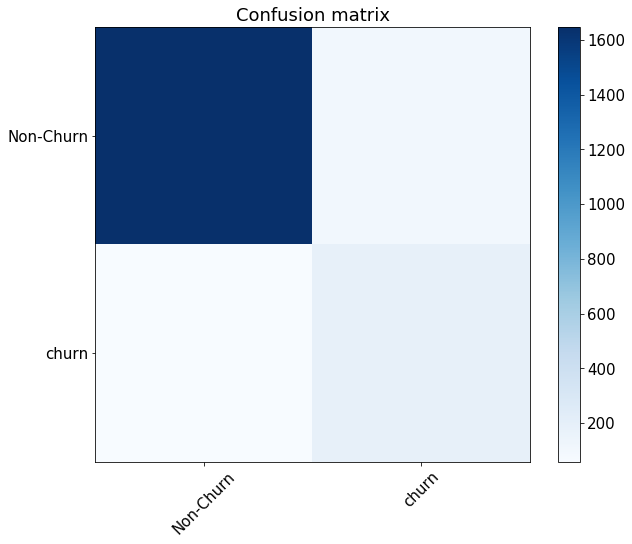

In [65]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [66]:
roc_auc_score(y_test, preds)

0.9526391069248211

Теперь попробуем применить к эмбеддингам медиану и максимальное значение.

In [81]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, how=np.median), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.097950,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.115390,...,0.000000,0.000000,0.0,0.045386,0.000000,0.0,0.089104,0.000000,0.0,0.007994
1,u108690,0.000000,0.0,0.0,0.026955,0.0,0.0,0.0,0.0,0.079384,...,0.005416,0.007159,0.0,0.000000,0.034020,0.0,0.025108,0.000000,0.0,0.023719
2,u108339,0.017834,0.0,0.0,0.018278,0.0,0.0,0.0,0.0,0.158872,...,0.068435,0.033429,0.0,0.000000,0.009234,0.0,0.037269,0.008563,0.0,0.026924


In [82]:
X = pd.merge(user_embeddings, target, 'left')

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [84]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15874534, 0.01871837, 0.60437436, 0.32324192, 0.05220738,
       0.0279474 , 0.24022582, 0.05454751, 0.13349515, 0.25584996])

In [85]:
median = calc_metrics(y_test, preds)

Best Threshold=0.291719, F-Score=0.781, Precision=0.775, Recall=0.788


In [86]:
roc_auc_median = roc_auc_score(y_test, preds)
roc_auc_median

0.9729216814931101

Мы получили более хороший результат.

In [87]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, how=np.max), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.444973,0.0,0.096534,0.125939,0.014994,0.0000,0.017142,0.0,0.245998,...,0.125606,0.116117,0.0,0.094975,0.000000,0.260145,0.224501,0.000000,0.113356,0.040109
1,u108690,0.057517,0.0,0.017669,0.086686,0.000000,0.0000,0.000000,0.0,0.296887,...,0.192373,0.078743,0.0,0.000000,0.305398,0.088452,0.090250,0.048604,0.088554,0.085226
2,u108339,0.182871,0.0,0.079344,0.080915,0.068575,0.0143,0.000000,0.0,0.286558,...,0.188809,0.235529,0.0,0.011516,0.163467,0.000000,0.065500,0.030374,0.090649,0.128491


In [88]:
X = pd.merge(user_embeddings, target, 'left')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [90]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1995103 , 0.00676398, 0.69084127, 0.25944843, 0.01832068,
       0.0021976 , 0.12947456, 0.03133528, 0.04016207, 0.09218758])

In [91]:
max_ = calc_metrics(y_test, preds)

Best Threshold=0.324206, F-Score=0.763, Precision=0.723, Recall=0.808


In [92]:
roc_auc_max_ = roc_auc_score(y_test, preds)
roc_auc_max_

0.9611721611721612

Этот результат оказался лучше, чем остальные.